In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets, transforms
import torch
from torch.utils.data import random_split, DataLoader

In [24]:
class_names = ['airplane', 'car',
               'bird', 'cat',
               'deer', 'dog',
               'frog', 'horse',
               'ship', 'truck']

# Trainset과 Testset 생성.

1. cifar10을 다운로드
2. train과 test를 위한 Dataset 생성.
  * `torch.tensor`로 변환.
  * `standaradization`을 수행.

In [25]:
data_path = os.path.join('dataset')

transform = transforms.Compose(
    [
        transforms.ToTensor(), # [C, H, W]
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        )
    ]
)

cifar10_train = datasets.CIFAR10(
    data_path,
    train = True,
    download = True,
    transform = transform,
)

cifar10_test = datasets.CIFAR10(
    data_path,
    train = False,
    download = True,
    transform = transform,
)

바이너리 타입으로 다운로드됨. (이미지아님)

In [27]:
print(f'{type(transform)     = }')
print(f'{type(cifar10_train) = }')
print(f'{type(cifar10_test)  = }')

type(transform)     = <class 'torchvision.transforms.transforms.Compose'>
type(cifar10_train) = <class 'torchvision.datasets.cifar.CIFAR10'>
type(cifar10_test)  = <class 'torchvision.datasets.cifar.CIFAR10'>


In [28]:
"__call__" in dir(transform) # callable object

True

In [29]:
type(transform).mro()

[torchvision.transforms.transforms.Compose, object]

In [30]:
type(cifar10_train).mro()

[torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object]

In [31]:
print(f'{len(cifar10_train) = }')
print(f'{len(cifar10_test)  = }')

len(cifar10_train) = 50000
len(cifar10_test)  = 10000


In [32]:
img, label = cifar10_train[0]
img.shape

torch.Size([3, 32, 32])

In [33]:
len(cifar10_train)

50000

## transform 객체 테스트!

* `transform` 객체는 `callable`이므로 하나의 이미지에 직접 적용하여 테스트 가능.
* 앞서 예제의 `transform` 객체는 PIL Image를 입력받아 정규화된 PyTorch 텐서를 반환함.

In [34]:
from torchvision.datasets import CIFAR10

# 변환 없이 원본 데이터 로드
cifar10_ori = CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=None,
    ) # 변환 없이 원본 데이터를 받기 위해 transformer를 None으로 해둠.

original_image, label = cifar10_ori[0]  # PIL Image
print(f"{type(original_image) = }, {type(label) = }")
print(f"{original_image.mode = }") # RGB, RGBA, L (grayscale), P (palette)
print(f"{original_image.getbands() = }")
print(f"{len(original_image.getbands()) = }")
print(f"{np.array(original_image).shape = }")
print("-"*10)
# transform 적용
transformed_tensor = transform(original_image)
print(f"Original shape: {original_image.size}")  # PIL: (width, height)
print(f"Transformed shape: {transformed_tensor.shape}")  # Tensor: [C, H, W]

type(original_image) = <class 'PIL.Image.Image'>, type(label) = <class 'int'>
original_image.mode = 'RGB'
original_image.getbands() = ('R', 'G', 'B')
len(original_image.getbands()) = 3
np.array(original_image).shape = (32, 32, 3)
----------
Original shape: (32, 32)
Transformed shape: torch.Size([3, 32, 32])


## Dataset 나누기.

### balanced class dataset with sufficient instances

In [42]:
train_size = int(0.8 * len(cifar10_train))
validation_size = len(cifar10_train) - train_size
train_set, validation_set = random_split(
    cifar10_train, [train_size, validation_size]
)


### stratified sampling

Stratified sampling이 필요한 경우는 다음과 같음:

1. 불균형한 클래스 분포 (imbalanced classes)
2. 작은 데이터셋 크기 (small dataset size)
3. 클래스별 샘플 수가 적어서 split 후에 특정 클래스가 누락될 가능성

In [43]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# =======================
# 인덱스와 레이블 추출

# cifar10_train 데이터셋의 모든 인덱스 리스트 생성
indices = list(range(len(cifar10_train)))

# 각 인덱스에 해당하는 데이터의 레이블(클래스) 리스트 생성
labels = [cifar10_train[i][1] for i in indices]

# ========================
# Stratified split

# train_test_split 함수를 사용하여 인덱스를 훈련 세트와 검증 세트로 분할
train_indices, val_indices = train_test_split(
    indices,
    test_size=0.2,   # 전체 데이터의 20%를 검증 세트로 할당
    stratify=labels, # 레이블 분포에 따라 계층적으로 분할하여 각 클래스의 비율을 유지
    random_state=42, # 랜덤 시드 설정하여 분할 결과 고정 (재현 가능성 확보)
)

# =======================
# Subset으로 분할

# cifar10_train 데이터셋에서 train_indices에 해당하는 부분으로 훈련 세트 생성
train_set = Subset(cifar10_train, train_indices)

# cifar10_train 데이터셋에서 val_indices에 해당하는 부분으로 검증 세트 생성
validation_set = Subset(cifar10_train, val_indices)

위에 이 과정을 생략하고 balanced~~만 하고 아래 코드 실행시, train & validation은 0.1 (10%) 에  근접하나, 유사도 비교할 때 false 뜰 수도 있음.

In [44]:
ori_labels = np.array([cifar10_train[i][1] for i in range(len(cifar10_train))])

train_labels = np.array([train_set[i][1] for i in range(len(train_set))])
val_labels = np.array([validation_set[i][1] for i in range(len(validation_set))])

ori_unique, ori_counts = np.unique(ori_labels, return_counts=True)
train_unique, train_counts = np.unique(train_labels, return_counts=True)
val_unique, val_counts = np.unique(val_labels, return_counts=True)

print("Original Ratios:  ", ori_counts / len(ori_labels))
print("Train Ratios:     ", train_counts / len(train_labels))
print("Validation Ratios:", val_counts / len(val_labels))

Original Ratios:   [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Train Ratios:      [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Validation Ratios: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


`np.allclose(a,b)`를 통해 두 배열 `a,b`들이 비슷한지 평가 가능:

* `rtol`: relative tolerance, 상대적 오차허용범위
* `atol`: absolute tolerance, 절대적 오차허용범위
* `|a-b| <= (atol+rtol * |b|)`



In [45]:
print(f"ori와 train의 class ratio가 유사:", np.allclose(ori_counts/len(ori_labels), train_counts/len(train_labels), rtol=0.01))

ori와 train의 class ratio가 유사: True


## DataLoader 생성

In [46]:
train_loader = torch.utils.data.DataLoader(
    train_set,       # 훈련 데이터셋 (Subset 또는 Dataset 객체)
    batch_size = 32, # minibatch의 크기: 한 번에 처리할 샘플 수 (메모리와 성능 고려)
    shuffle = True,  # 매 epoch마다 데이터 순서를 섞음 (overfitting 방지, improves generalization)
    num_workers = 0, # 데이터 로딩에 사용할 subprocess 수 (0=main process만 사용)
)

val_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size = 32, # 훈련과 동일한 배치 크기 (일관성 유지)
    shuffle = False, # 검증 시에는 순서를 섞지 않음 (재현 가능한 결과를 위해 = 일관된 평가!)
    num_workers = 0,
)

test_loader = torch.utils.data.DataLoader(
    cifar10_test,
    batch_size = 32,
    shuffle = False, # 테스트 시에는 순서를 섞지 않음 (일관된 평가를 위해)
    num_workers = 0,
)

# DataLoader Test

type(grid_img)=<class 'torch.Tensor'>
max_val.item()=2.126077890396118
min_val.item()=-1.989878535270691
type(grid_img)=<class 'torch.Tensor'>
mean_val.item()=0.1445523053407669
std_val.item()=1.0396915674209595


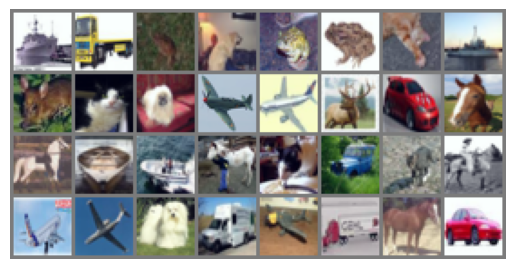

In [48]:
# 데이터 로더에서 데이터셋의 첫 번째 배치를 가져옴
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지를 그리드 형태로 만들기 위해 여러 이미지를 하나로 결합함
grid_img = torchvision.utils.make_grid(images)

# 그리드 이미지에서 최대값과 최소값, 표준편차와 평균을 계산함
max_val = torch.max(grid_img)
min_val = torch.min(grid_img)
std_val = torch.std(grid_img)
mean_val= torch.mean(grid_img)

# 그리드 이미지의 타입, 최대값, 최소값, 평균, 표준편차를 출력함
print(f'{type(grid_img)=}\n{max_val.item()=}\n{min_val.item()=}')
print(f'{type(grid_img)=}\n{mean_val.item()=}\n{std_val.item()=}')

# 그리드 이미지를 정규화함 (값을 0과 1 사이로 조정함)
normalized_grid_img = (grid_img - min_val) / (max_val - min_val)

# 이미지를 matplotlib를 사용하여 시각화함
# 이미지는 (C, H, W) 형식이므로 (H, W, C) 형식으로 변경함
plt.imshow(np.transpose(normalized_grid_img, (1, 2, 0)))
plt.axis('off')
plt.show()

# 기타...

In [49]:
cifar10_train = datasets.CIFAR10(
    data_path,
    train = True,
    download = True,
    # transform = transform,
)

In [50]:
img, label = next(iter(cifar10_train))

# print(img.numpy().shape)
print(f'{type(img) = }')

type(img) = <class 'PIL.Image.Image'>


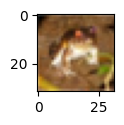

In [51]:
plt.figure(figsize=(1,1))
plt.imshow(np.array(img))

In [52]:
np.max(img)

np.uint8(255)